Importamos los datos de una nueva base de datos obtenida de UC Irvine Machine Learning Repository, donde queremos predecir si un hongo es venesoso o no. Esto se determina en la columna de class_num, donde un 1 indica que si es venenoso y por el contrario el 0 indicaria que no lo es. Después de aplicar one-hot encoding, cada posible valor se convirtió en una columna booleana. Despues, dividimos en train (80%) y test (20%) con el mismo balance de datos que se muestra a continuacion junto a las dimensiones.


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("mushroom_clean_onehot.csv")

print("Dimensiones:", df.shape)
print(df.head())

# Variable de salida
y = df["class_num"]

# Variables predictoras
X = df.drop(columns=["class_num"])

# Separar train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resultados 
print("Dimensiones totales:", X.shape)
print("Dimensiones train:", X_train.shape)
print("Dimensiones test:", X_test.shape)

print("\nDistribución en dataset completo:")
print(y.value_counts(normalize=True))

print("\nDistribución en train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en test:")
print(y_test.value_counts(normalize=True))

Dimensiones: (8124, 139)
   class_num  cap-shape_b  cap-shape_c  cap-shape_f  cap-shape_k  cap-shape_s  \
0          1            0            0            0            0            0   
1          0            0            0            0            0            0   
2          0            1            0            0            0            0   
3          1            0            0            0            0            0   
4          0            0            0            0            0            0   

   cap-shape_x  cap-shape_nan  cap-surface_f  cap-surface_g  ...  \
0            1              0              0              0  ...   
1            1              0              0              0  ...   
2            0              0              0              0  ...   
3            1              0              0              0  ...   
4            1              0              0              0  ...   

   population_y  population_nan  habitat_d  habitat_g  habitat_l  habitat_m  \


Posteriormente, con ayuda de una regresion logistica simple, craemos un modelo para indicar las 2 variables mas relevantes para este estudio y posteriormente unicamente trabajar con esas dos, eliminando todas lsa demas.

In [65]:
import statsmodels.api as sm

# Modelo logístico con todas las variables
X_train_sm = sm.add_constant(X_train)
model = sm.GLM(y_train, X_train_sm, family=sm.families.Binomial())
result = model.fit()

# Resumen del modelo
print(result.summary())

C:\Users\nelso\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\nelso\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\nelso\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\nelso\anaconda3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparat

                 Generalized Linear Model Regression Results                  
Dep. Variable:              class_num   No. Observations:                 6499
Model:                            GLM   Df Residuals:                     6364
Model Family:                Binomial   Df Model:                          134
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.5569e-09
Date:                Wed, 01 Oct 2025   Deviance:                   5.1027e-09
Time:                        22:41:27   Pearson chi2:                 2.55e-09
No. Iterations:                    27   Pseudo R-squ. (CS):             0.7497
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
cap-shape_b     

Como se pudo observar, Python muestra una advertencia que muestra que las variables tienen un 100% de precision, esto se debe a que al estar trabajando con una base de datos que previamente paso por un proceso de one-hot encoding, todas sus varibles son dummies que muestran 0's o 1's. Por esto mismo, interpretar las variables por sus valores de p no tendria sentido, por lo que acudimos a usar las variables que mas afecten a nuestra salida. Para esto, hacemos uso del odds ratio y buscamos las variables que afecten de manera positiva como negativa a las odds.

In [33]:
import pandas as pd
import numpy as np

# Odds ratio (útil para interpretar)
coef_df["OR = exp(Coef)"] = np.exp(coef_df["Coef"])

# 3) Separar los más positivos y más negativos (dirección del efecto)
print("\nMayor positivo:")
print(coef_df.sort_values("Coef", ascending=False).head(1)[["Variable", "Coef", "OR = exp(Coef)"]])

print("\nMayor negativo:")
print(coef_df.sort_values("Coef", ascending=True).head(1)[["Variable", "Coef", "OR = exp(Coef)"]])



Mayor positivo:
                Variable        Coef  OR = exp(Coef)
118  spore-print-color_r  103.433211    8.326699e+44

Mayor negativo:
          Variable       Coef  OR = exp(Coef)
105  ring-number_t -31.668724    1.763794e-14


Para este caso, estaremos usando las variables de 'spore-print-color_r' y 'ring-number_t' para precedir si el hongo es venenoso o no. Tomando en cuenta covarianzas iguales por clase, LDA induce una frontera lineal en el plano de donde la probabilidad de pertenecer a la clase 1 es ≈ 0.5. Seleccionamos las dos columnas (X2) y la etiqueta (y) para despeus ajustar el modelo LinearDiscriminantAnalysis y asi generar una malla regular en el plano de (x₁, x₂) y predecir la clase en cada punto para visualizar la partición (regiones de decisión). Por uiltimo, superponemos todas las observaciones distinguiéndolas por clase (color/marcador).

In [86]:
# variables a graficar
X2 = df[['spore-print-color_r', 'ring-number_t']]    
y  = df['class_num']

# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X2, y)

# puntos para dibujar la frontera
import numpy as np
import matplotlib.pyplot as plt
x_min, x_max = X2.iloc[:,0].min()-1, X2.iloc[:,0].max()+1
y_min, y_max = X2.iloc[:,1].min()-1, X2.iloc[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = lda.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# graficar
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm') 

# puntos de cada clase con marcador distinto
for clase in np.unique(y):
    plt.scatter(X2[y==clase].iloc[:,0],
                X2[y==clase].iloc[:,1],
                label=f'Clase {clase}')

plt.xlabel('spore-print-color_r')
plt.ylabel('ring-number_t')
plt.legend()
plt.title('LDA - Frontera discriminante')
plt.show()
X2.value_counts()


C:\Users\nelso\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearDiscriminantAnalysis was fitted with feature names
  warnings.warn(


spore-print-color_r  ring-number_t
0                    0                7524
                     1                 528
1                    1                  72
Name: count, dtype: int64

Lo que se observa en la grafica de arriba podria parecer inusual, pero como ambas variables son dummies (0/1), solo existen cuatro coordenadas posibles: (0,0), (0,1), (1,0), (1,1). Muchas observaciones caen exactamente en los mismos puntos y se enciman en la gráfica (esto se ve al final donde ) esto no invalida la visualización, simplemente muestra que el espacio 2D es discreto. El sombreado de fondo representa la regla de decisión del modelo, independientemente de la discreción de los datos.

Ahora, entrené un árbol base para tener una referencia y visualizar su estructura. Después, generé una lista de candidatos para 
𝛼(parámetro alpha) usando la ruta de poda del propio árbol y seleccioné el valor óptimo mediante Leave-One-Out Cross-Validation (LOOCV), optimizando el F1-score. Con 𝛼 obtenido, reentrené el árbol podado para poder visualizar la partición en una gráfica de variable 1 vs variable 2, proyecté el modelo a las dos variables binarias elegidas (spore-print-color_r y ring-number_t).

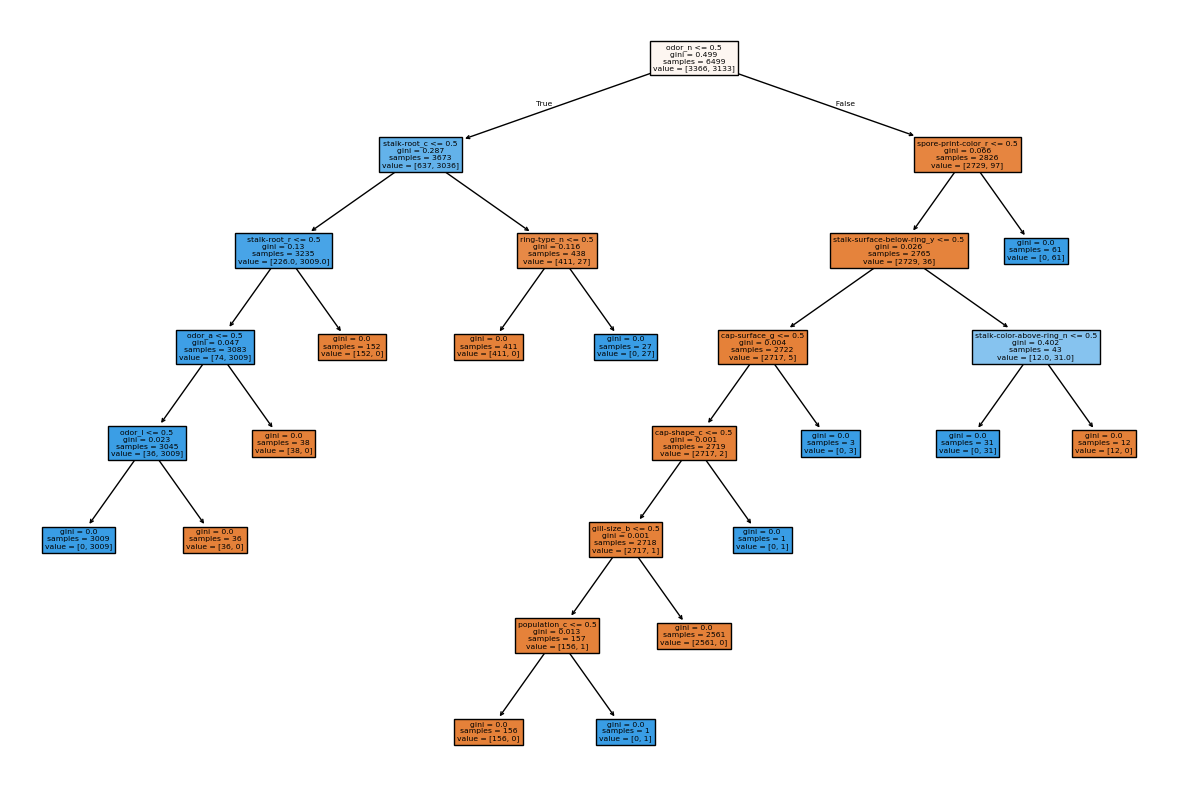

Best alpha: 0.001


In [52]:
from sklearn.tree import DecisionTreeClassifier as DTC
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.tree import plot_tree
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold

# arbol
tree = DTC().fit(X_train, y_train)
plt.figure(figsize=(15,10))
plot_tree(tree, filled=True, feature_names=X_train.columns);
plt.show()

# Generar objeto de validación cruzada
skf = StratifiedKFold(n_splits=5)

# Generar secuencia de valores
ccp = np.linspace(0.001, 0.2, 250)

# Inicializar variable de salida
cv_scores = []

# Ciclo donde se calcula el f1-score mediante validación cruzada
for alpha in ccp:
      pruned_tree = DTC(ccp_alpha=alpha)
      cv_scores.append(np.mean(cross_val_score(pruned_tree, X_train, y_train, cv=skf, scoring='f1')))
# Encontrar el alpha óptimo
alpha = ccp[np.argmax(cv_scores)]

# Imprimir resultados
print("Best alpha:",alpha)
# Generar y entrenar el árbol podado
pruned_tree = DTC(ccp_alpha=alpha).fit(X_train, y_train)

# Visualizar árbol
plot_tree(pruned_tree, filled=True, feature_names=X_train.columns);
plt.show()

Para finalizar el experimento, buscamos comparar el desempeño. Para eso, evalue ambos modelos sobre el conjunto de prueba usando accuracy, precision, sensibilidad, F1, AUC-ROC y Average Precision (AP), además de la matriz de confusión, la curva ROC y la curva Precision–Recall.

LDA (2 variables): entrenado únicamente con spore-print-color_r y ring-number_t.

Árbol de decisión podado: entrenado con el conjunto usado en la sección anterior (si lo entrenaste con todas las variables, lo evaluamos así; si lo hiciste con 2 variables para la partición 2D, también incluyo esa opción para comparar “en igualdad de condiciones”).

Dado que ambas variables seleccionadas son dummies (0/1), el espacio es discreto y muchas observaciones comparten coordenadas. En este contexto, el árbol suele capturar mejor interacciones lógicas (p. ej., reglas tipo “si ring=1 entonces…”) mediante cortes eje-alineados, mientras que LDA impone una frontera lineal. Por ello, espero que el árbol obtenga F1/AP igual o ligeramente superior si la regla verdadera depende de combinaciones de 0/1; el AUC-ROC puede ser similar. No obstante, la decisión final se toma por las métricas observadas en test.

Accuracy     = 0.9982 (99.82%)
Sensitivity  = 0.9962 (99.62%)
Specificity  = 1.0000 (100.00%)
Precision    = 1.0000 (100.00%)
F1 score     = 0.9981


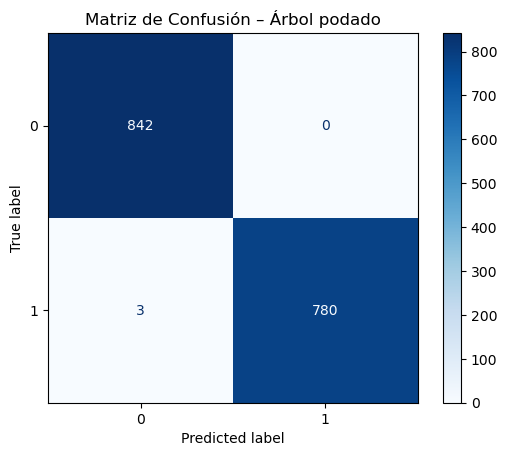

AUC (ROC)               : 0.9985


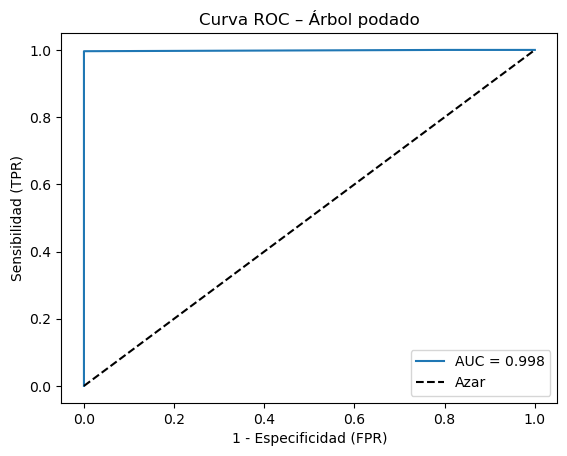

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    balanced_accuracy_score, roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score, log_loss
)
# predicciones
y_pred = pruned_tree.predict(X_test)

# metricas escalares
acc  = (tp + tn) / (tp + fp + tn + fn) if (tp + fp + tn + fn) else np.nan
sens = tp / (tp + fn) if (tp + fn) else np.nan         
spec = tn / (tn + fp) if (tn + fp) else np.nan          
prec = tp / (tp + fp) if (tp + fp) else np.nan          
f1   = (2 * prec * sens / (prec + sens)) if (prec + sens) else np.nan

print(f"Accuracy     = {acc:.4f} ({acc*100:.2f}%)")
print(f"Sensitivity  = {sens:.4f} ({sens*100:.2f}%)")
print(f"Specificity  = {spec:.4f} ({spec*100:.2f}%)")
print(f"Precision    = {prec:.4f} ({prec*100:.2f}%)")
print(f"F1 score     = {f1:.4f}")

# matriz confusion
cm = confusion_matrix(y_test, y_pred, labels=pruned_tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pruned_tree.classes_)
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión – Árbol podado")
plt.show()

# curva roc
fpr, tpr, _ = roc_curve(y_test, proba, pos_label=pos_label)
roc_auc = auc(fpr, tpr)
print(f"AUC (ROC)               : {roc_auc:.4f}")

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar')
plt.xlabel('1 - Especificidad (FPR)')
plt.ylabel('Sensibilidad (TPR)')
plt.title('Curva ROC – Árbol podado')
plt.legend()
plt.show()

